## XGB Regressor

In [26]:
# Lets import our necessary libraries
import pandas as pd
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [27]:
# Create our list of dataframes containing each dataset
df = pd.read_csv('../Data/dataset83.csv')

In [28]:
# Remove unecessary data
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

In [29]:
label_encoder = LabelEncoder()

df['Species'] = label_encoder.fit_transform(df['Species'])
df['Population'] = label_encoder.fit_transform(df['Population'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Converting a column to float
df['Thorax_length'] = pd.to_numeric(df['Thorax_length'], errors='coerce').astype('float64')

# Converting a column to int (after ensuring it's first converted to float to handle non-integer formats)
df['wing_loading'] = pd.to_numeric(df['wing_loading'], errors='coerce').astype('float64')



for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=1.0,
                              colsample_bynode=0.9694742203008602,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.29999999999999993, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                         

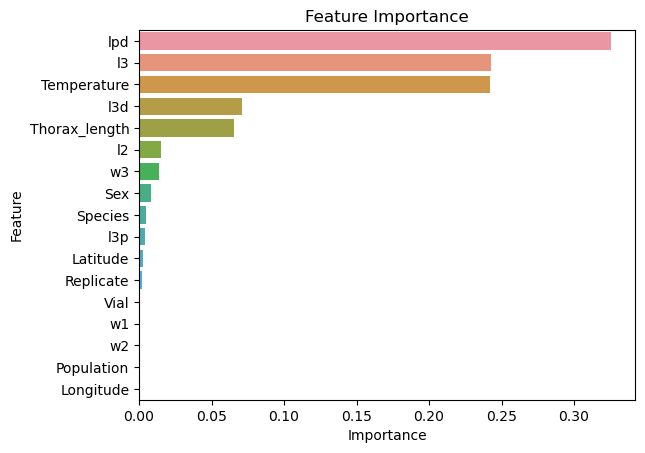

In [30]:
# Assuming 'df' has been loaded and preprocessed similarly for both models:
X = df.drop(columns='wing_loading')
y = df['wing_loading']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=420)

# Define the model
model = XGBRegressor(random_state=420)

# Create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Ensure scaling is part of the pipeline to prevent data leakage
    ('xgb', model)
])

# Define the search space for hyperparameters
search_space = {
    'xgb__max_depth': Integer(3, 10),
    'xgb__learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'xgb__subsample': Real(0.5, 1.0),
    'xgb__colsample_bytree': Real(0.5, 1.0),
    'xgb__colsample_bylevel': Real(0.5, 1.0),
    'xgb__colsample_bynode': Real(0.5, 1.0),
    'xgb__reg_alpha': Real(0.001, 10.0),
    'xgb__reg_lambda': Real(0.001, 10.0),
    'xgb__gamma': Real(0.0, 5.0),
    'xgb__n_estimators': Integer(100, 500)
}

# Using BayesSearchCV for optimization
opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=30, scoring='neg_mean_squared_error', random_state=420)
opt.fit(X_train, y_train)

# Best estimator and scores
print("Best Estimator:", opt.best_estimator_)
print("Best MSE:", -opt.best_score_)  # Convert back from negative MSE
test_r2 = opt.best_estimator_.score(X_test, y_test)
print("Test R^2 score:", test_r2)

# Predictions
y_pred = opt.best_estimator_.predict(X_test)

# Feature Importance
xgboost_model = opt.best_estimator_.named_steps['xgb']
importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgboost_model.feature_importances_}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance')
plt.show()

In [31]:
# Making predictions
y_pred = opt.best_estimator_.predict(X_test)

# Calculate R^2 and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Best Estimator: {opt.best_estimator_}")
print(f"Best Score (MSE from CV): {-opt.best_score_}")  # Convert back from negative MSE
print(f"Test MSE: {test_mse}")
print(f"Test R^2: {test_r2}")

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=1.0,
                              colsample_bynode=0.9694742203008602,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.29999999999999993, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                         

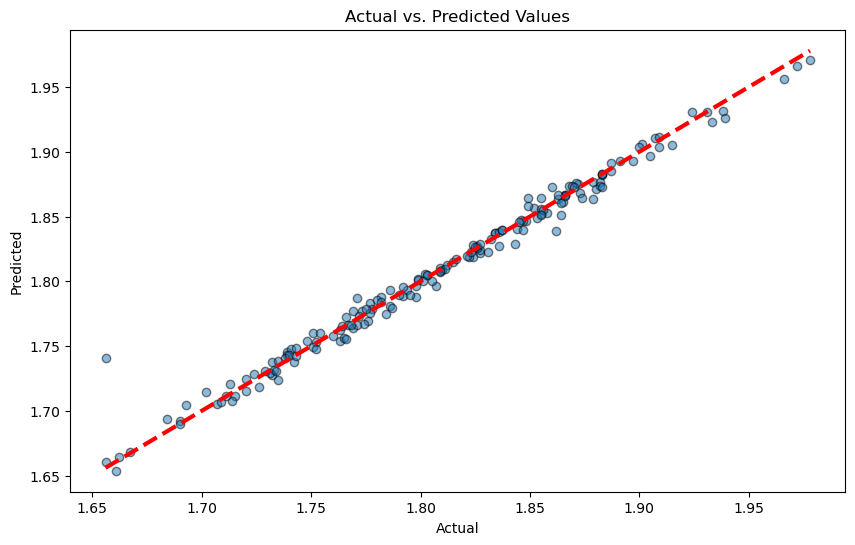

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


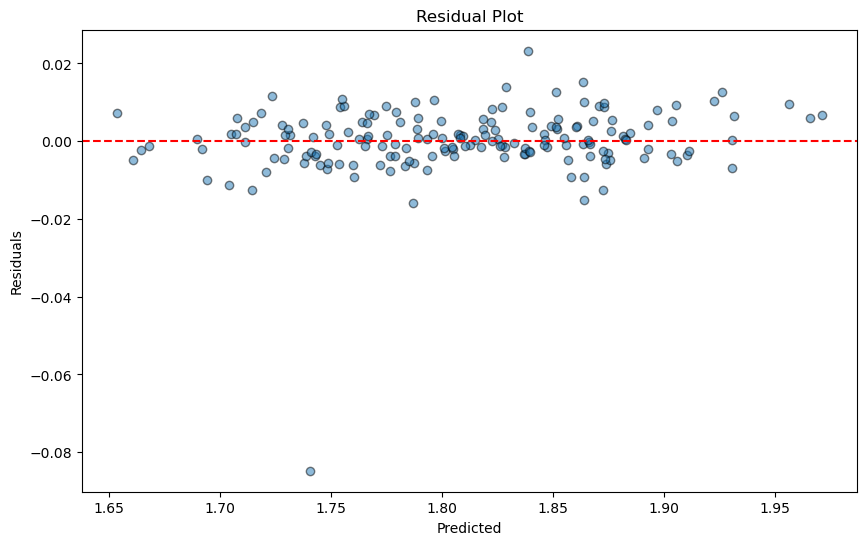

In [33]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


/home/adam/miniconda3/envs/datascience/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


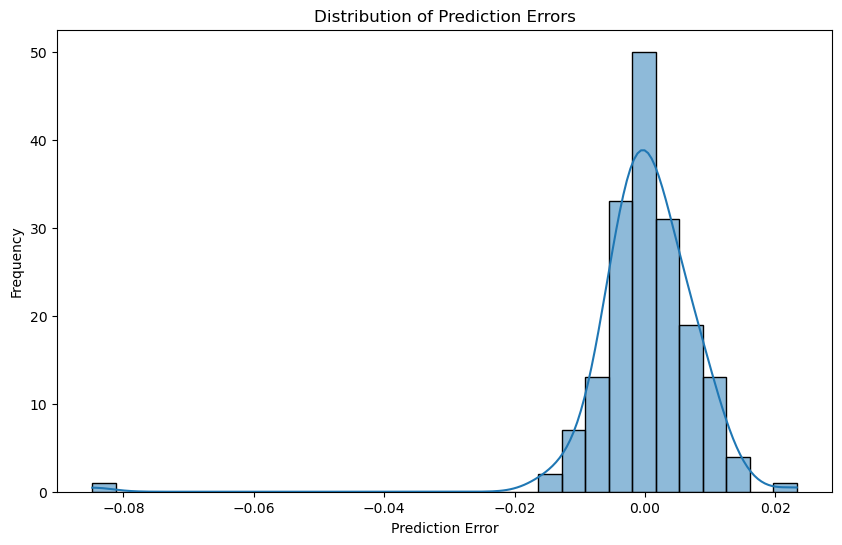

In [34]:
errors = residuals  # Which are y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()